# Lesson 6 // APIs

In the last few notebooks we've been analyzing twitter data that was collected and collated for us. In this notebook we'll see how to gather Twitter data ourselves, using Twitter's APIs. In doing so we'll also learn the basics of gathering data more generally using APIs.

An API is an *Application Program Interface*, a way of accessing the functionality of a program from inside another program. APIs are software that act as intermediaries between two applications (in our context, a requester (you) and a website server). The API provides data in a standardized, efficient way, but first you need to know how to request things - APIs will differ in how this is done. You usually also need to get authorization to use the API beforehand.

R has some packages for interacting with some of the most commonly used APIs like twitter, facebook, etc. The **httr** package is a more general way of making *http* requests to an API and can be used in cases where there's no specialist package (if there is, it'll often be easier to use that than **httr**).

In the notebook we will:

1. Gather tweets and related data by searching against a sampling of recent tweets published in the past 7 days, using the **twitteR** package. The **twitteR** package provides an easy-to-use interface to the Twitter Search API.
2. Gather tweets directly from the twitter stream (rather than a sample), using the **streamR** package. The **streamR** package provides an interface to the Twitter Streaming API.
3. Show how you can do the same thing using the more general **httr** package, which is useful for cases where there is not a special purpose package for interacting with a particular API.


First load the required packages.

In [1]:
library(streamR)
library(twitteR)
library(tidyverse)
library(ggmap)
library(jsonlite)
library(httr)
library(stringr)

Loading required package: RCurl
Loading required package: bitops
Loading required package: rjson
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
complete(): tidyr, RCurl
filter():   dplyr, stats
id():       dplyr, twitteR
lag():      dplyr, stats
location(): dplyr, twitteR

Attaching package: 'jsonlite'

The following object is masked from 'package:purrr':

    flatten

The following objects are masked from 'package:rjson':

    fromJSON, toJSON



## Accessing the Twitter Search API using twitteR

Twitter Search API is part of Twitter’s REST API. It allows queries against the indices of recent or popular Tweets and behaves similarly to, but not exactly like the Search feature available in Twitter mobile or web clients, such as Twitter.com search. 

The Twitter Search API searches a sample of recent Tweets made in the last 7 days. When interpreting results its important to know that data collected in this way will not consist of *all* tweets (e.g. on a topic, by a user), just a sample of these. In other respects the Search API is similarly to using the search feature available on Twitter (e.g. see [Twitter.com](https://twitter.com/)).

Later on we will interface with Twitter Search API using **httr**. In this example, we're going to see how to interface with the API using the **twitteR** package. The results will be the same, and you could use either. The benefit of using **twitteR** is that it has been specifically designed of use with the Twitter Search API, and only that API, so it is a bit easier to use and you won't have to go wading through the API documentation. The **httr** package is more general, so it doesn't have e.g. functions that deal specifically with Twitter.

### Setting up a Twitter app

Many APIs require you to authenticate with OAuth tokens. OAuth is an open standard for token-based authentication on the Internet. Essentially, the Twitter API allows you to access various parts of Twitter's data resources. To use the API, Twitter needs to know who you are, and OAuth is the standard way of doing this. 

For the Twitter API, authentication is done through creating your own Twitter Application, which is linked to your Twitter account. Twitter grants the authentication token to your app, but since this is linked to your account it gives Twitter a way of tracing the requests back to you. The fact that we are setting up an "app" is not important - from our point-of-view this app will not do anything, it is just a way to tell Twitter who we are when we make requests for data.

So, we're now going to set up our own Twitter app and get the authentication details. 

The following instructions are adapted from [here](http://thinktostart.com/twitter-authentification-with-r/).

1. Go to https://apps.twitter.com/ and log in with your Twitter Account (you need a Twitter account to do this). Click the "Create new app" button.

2. Enter the details of your app on the screen that follows:
    + *Name*: this needs to be unique, so something like "test" won't be allowed, but other than that it doesn't matter what you call the app since you're the only person using it. 
    + *Description*: enter anything you want
    + *Website*: Enter any valid URL as the website (I use `http://www.stats.uct.ac.za/`). 
    + *Callback URL*: this is the only important bit! Enter `http://127.0.0.1:1410`. 
    + Tick the box that says you agree with the conditions of use.
    + Click the button that says "Create your twitter application".

3. You now need to get and write down your authentication details. 
    + Select the "Keys and Access Tokens" tab, 
    + Copy and paste the Consumer key (API key) and Consumer secret (API secret)
    + Click on "Create my access token" near the bottom of the page. Copy and paste the "Access Token" and "Access Token Secret". 

### Completing the OAuth authentication process in RStudio

1. Open up R/RStudio and load the **twitteR** package

2. Create variables for each of the authentication details you copied down previously. I save these to an .RData file for later use in the last line below but this is not really necessary (it just means I don't have to show you my authentication details in this notebook!). Remember not to share these details - they're passwords.
```
api_key <- "xxxxxxxxxxxxxx"
api_secret <- "xxxxxxxxxxxxxx"
access_token <- "xxxxxxxxxxxxxx-xxxxxxxxxxxxxx"
access_token_secret <- "xxxxxxxxxxxxxx"
save(api_key, api_secret, access_token, access_token_secret, file="my_twitteR_oauth.RData")
```
3. We now get OAuth authentication by passing the `setup_twitter_oauth()` function our `api_key` and `api_secret` from before (or by loading it again if saved as .RData i.e. `load(my_twitteR_oauth.RData)`).
```
setup_twitter_oauth(api_key,api_secret)
```
This will open up a web page that says "Authorize <YourTwitterAppName> to use your account?". Click "Authorize App" and return to R/RStudio. You should see a message "Authentication Complete". You're now done!

### Using twitteR to collect data

We need to start each session by providing our authentication details (you only need to create the OAuth token once, which we've done above, but you need to authenticate *every* twitteR session). 

In [2]:
# load authentication details into R (or just load api_key and api_secret as done above)
load("my_twitteR_oauth.RData") 

# get OAuth authentication 
setup_twitter_oauth(api_key,api_secret)

[1] "Using browser based authentication"


Waiting for authentication in browser...
Press Esc/Ctrl + C to abort
Please point your browser to the following url: 
https://api.twitter.com/oauth/authenticate?oauth_token=GqCRRwAAAAAA2dPZAAABXrhabI0&permission=read
Authentication complete.


Let's collect 100 tweets using the #GuptaLeaks hashtag:

In [3]:
# get some tweets
tweets <- searchTwitter('#GuptaLeaks', n=100)
str(tweets[[1]])

Reference class 'status' [package "twitteR"] with 17 fields
 $ text         : chr "RT @tumisole: #countryDuty\n\n#GuptaLeaks \n\nIt must have been an interesting meeting <ed><U+00A0><U+00BE><ed>"| __truncated__
 $ favorited    : logi FALSE
 $ favoriteCount: num 0
 $ replyToSN    : chr(0) 
 $ created      : POSIXct[1:1], format: "2017-09-25 09:15:23"
 $ truncated    : logi FALSE
 $ replyToSID   : chr(0) 
 $ id           : chr "912244127017906177"
 $ replyToUID   : chr(0) 
 $ statusSource : chr "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>"
 $ screenName   : chr "RevolutionII_ZA"
 $ retweetCount : num 233
 $ isRetweet    : logi TRUE
 $ retweeted    : logi FALSE
 $ longitude    : chr(0) 
 $ latitude     : chr(0) 
 $ urls         :'data.frame':	0 obs. of  4 variables:
  ..$ url         : chr(0) 
  ..$ expanded_url: chr(0) 
  ..$ dispaly_url : chr(0) 
  ..$ indices     : num(0) 
 and 53 methods, of which 39 are  possibly relevant:
   getCreated, g

In [4]:
# view the data collected
head(tweets)

[[1]]
[1] "RevolutionII_ZA: RT @tumisole: #countryDuty\n\n#GuptaLeaks \n\nIt must have been an interesting meeting <ed><U+00A0><U+00BE><ed><U+00B4><U+0094>\n\n<ed><U+00A0><U+00BD><ed><U+00B3><U+00B7>@CraigMcKune https://t.co/iXP5sq169j"

[[2]]
[1] "neiljohnsonza: RT @KayaFMTalk: [LISTEN] @portiakobue &amp; @CoruscaKhaya dissect KPMG situation. From CEO to #guptaleaks implications\n\nhttps://t.co/WMGtRrHXCe"

[[3]]
[1] "kayafm95dot9: RT @KayaFMTalk: [LISTEN] @portiakobue &amp; @CoruscaKhaya dissect KPMG situation. From CEO to #guptaleaks implications\n\nhttps://t.co/WMGtRrHXCe"

[[4]]
[1] "siphoandrew13: RT @JacaNews: #GuptaLeaks: Sisulu asks ANC Disciplinary Committee to act https://t.co/OWZe5Wk92g. https://t.co/0IYF1iBEgT"

[[5]]
[1] "KayaFMTalk: [LISTEN] @portiakobue &amp; @CoruscaKhaya dissect KPMG situation. From CEO to #guptaleaks implications\n\nhttps://t.co/WMGtRrHXCe #Thethani #KPMG"

[[6]]
[1] "precipicelance: @The_New_Age Yeah like the #GuptaLeaks , neh."


We can clean up the tweets by removing links and filtering out retweets, for example, using regular expressions.

In [5]:
# converts a list of objects from a single twitteR class and returns a data.frame
tweets_df <- twListToDF(tweets)

# clean up tweets
replace_reg <- "(https?:.*?([\\s]|[a-zA-Z0-9]$))|(www:.*?([\\s]|[a-zA-Z0-9]$))|&amp;|&lt;|&gt;|RT"
tweets_df <- tweets_df %>% as.tibble() %>%
  filter(!str_detect(text, "^RT")) %>%
  mutate(value = str_replace_all(text, replace_reg, ""))

tweets_df %>% select(value)

value
[LISTEN] @portiakobue @CoruscaKhaya dissect KPMG situation. From CEO to #guptaleaks implications #Thethani #KPMG
"@The_New_Age Yeah like the #GuptaLeaks , neh."
#GuptaLeaks: Sisulu asks ANC Disciplinary Committee to act.
@SAP promises update on investigation into allegations of #wrongdoing in its #SouthAfrican business ~ ~ #GuptaLeaks
Brown ‘clarifies’ legal action order against McKinsey via @BDliveSA #Eskom #StateCapture #GuptaLeaks #Corruption
@OUTASA @KPMG_SA What beverage costs 364 000? #Guptas #guptaleaks @mgigaba #SARS
@Derek_Hanekom I agree with @LindiweSisuluSA that those mentioned in #GuptaLeaks should be disciplined Start with @SAPresident and @mgigaba
#GuptaLeaks: Sisulu asks ANC Disciplinary Committee to act
"@Pheli7812 @Eusebius He has always been strategically placed for a reason. Served the master by being the catalyst,…"
"Today is #HeritageDay Let's celebrate corruption, #Zuma #GuptaLeaks and so much more to fuck #SouthAfrica up!"


The data we collected doesn't just cover the text of the tweet. Twitter sends a whole lot of other information, including each user's location (a string the user enters when signing up for a twitter account). Here we extract the location strings and use the Google Maps API to try and find the approximate latitude and longitude of each user's location. 

In [6]:
# lookup user info
user_info <- lookupUsers(tweets_df$screenName)  
user_df <- twListToDF(user_info)  

# use google maps API to get lat/lon from given user location (one of the exercises!)
located_users <- !is.na(user_df$location)
locations <- geocode(user_df$location[located_users])  

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Parktown%20North,%20Johannesburg&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Republic%20of%20Zupta&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Gauteng&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=South%20Africa&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=MIDRAND,SOUTH%20AFRICA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=London,%20England&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Midrand&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Islington,%20London&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Kuvukiland,%20South%20Africa&

We then plot this using **ggmap**, an extension to **ggplot2** to interface with Google Maps.

Using zoom = 4...
Map from URL : http://tile.stamen.com/toner-lite/4/7/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/8/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/9/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/10/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/11/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/7/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/8/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/9/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/10/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/11/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/7/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/8/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/9/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/10/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/11/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/7/7.png
Map from URL : http://tile.stame

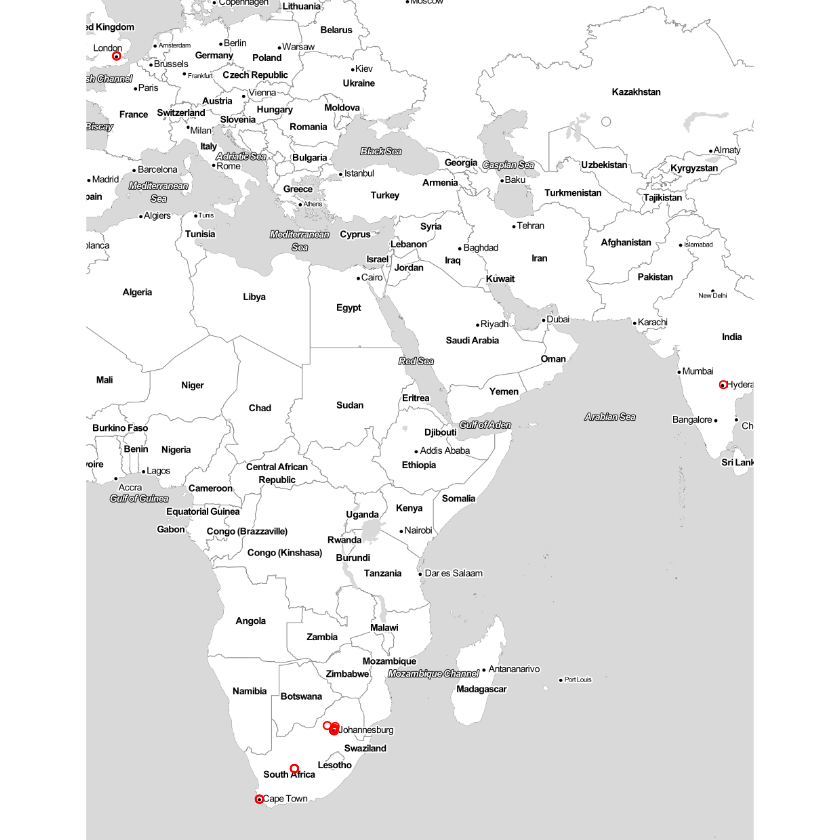

In [7]:
# plot tweets
qmplot(lon, lat, data = locations, geom="blank") +
  geom_point(data = locations, aes(x = lon, y = lat),
             colour = I("red"), shape = 1)

Below is a few more ways to use the `searchTwitter()` function, applying various filters to the search:

In [8]:
# filter by date
tweets <- searchTwitter('#GuptaLeaks', n=100, since='2017-08-23', until='2017-08-25')

Warning message in doRppAPICall("search/tweets", n, params = params, retryOnRateLimit = retryOnRateLimit, :
"100 tweets were requested but the API can only return 0"

In [9]:
# filter by resultType (mixed [default], recent, popular)
tweets_rec <- searchTwitter('#GuptaLeaks', n=100, resultType = "recent")
tweets_pop <- searchTwitter('#GuptaLeaks', n=100, resultType = "mixed")

In [10]:
# filter by location

# constantia
tweets_con <- searchTwitter('#GuptaLeaks', n=100, geocode='-34.02273,18.44813,10mi')
# saxonwold
tweets_sax <- searchTwitter('#GuptaLeaks', n=100, geocode='-26.16058,28.04098,10mi')

## Accessing the Twitter Streaming API using streamR

The tweets that twitteR provides is based on a static snapshot of tweets that twitter provides, going back one week. An alternative way to use the twitter API is to use the **streamR** package to collect tweets through time.

You first need to create *another* twitter app and get authentication details. You do this in exactly the same way as before except that **you must leave the callback URL blank** (don't ask me why). Do that once, and save your Consumer key (API key), Consumer secret (API secret), Access token, and Access token secret. 

### Completing the OAuth authentication process in RStudio

1. Open up R/RStudio and load the **twitteR** package

2. Create variables for each of the authentication details you copied down previously
```
library(ROAuth)
api_key <- "xxxxxxxx"
api_secret <- "xxxxxxxx"
access_token <- "xxxxxxxxxxxxxx-xxxxxxxxxxxxxx"
access_token_secret <- "xxxxxxxxxxxxxx"
```
3. We now get OAuth authentication with the `OAuthFactory()` function. This is a bit more complicated that before but essentially we are still just passing `api_key` and `api_secret` to the function. 
```
my_oauth <- OAuthFactory$new(consumerKey = api_key, consumerSecret = api_secret, 
                             requestURL = "https://api.twitter.com/oauth/request_token", 
                             accessURL = "https://api.twitter.com/oauth/access_token", 
                             authURL = "https://api.twitter.com/oauth/authorize" )
my_oauth$handshake(cainfo = system.file("CurlSSL", "cacert.pem", package = "RCurl"))
save(my_oauth, file = "my_oauth.Rdata")
```

### Using streamR to collect data

As before we need to start each session by providing our authentication details (you would only do the previous parts *once*, but you need to do the bit below *every* session).

In [12]:
# load your OAuth token
load("my_oauth.Rdata")

We capture tweets using the `filterStream()` function. There are various ways to use `filterStream()`. We can keep the stream open until we have collected a specified number of tweets, or for some time interval. It is also possible to follow certain people, or hashtags (see the help for details). Here we just show two uses.

In [14]:
# capture 10 tweets mentioning the "HurricaneHarvey" hashtag
filterStream(file.name="harvey_tweets.json",
              track="#TakeAKnee", tweets=10, oauth=my_oauth)

Capturing tweets...
Connection to Twitter stream was closed after 2 seconds with up to 10 tweets downloaded.


In [15]:
# capture tweets mentioning the "HurricaneHarvey" hashtag for 30s
filterStream(file="harvey_tweets.json",
              track="#TakeAKnee", timeout=30, oauth=my_oauth)

Capturing tweets...
Connection to Twitter stream was closed after 30 seconds with up to 130 tweets downloaded.


Parse the tweets to get them into a readable form (if you get an error, you may have no tweets!)

In [16]:
harvey_tweets <- readTweets(tweets="harvey_tweets.json")

58 tweets have been parsed. 


We can view the text of the first tweet:

In [17]:
harvey_tweets[[1]]$text

[1] "RT @W_C_Patriot: It's not about freedom of speech.It's about common decency and respect @TianaDalichov\n#TakeAKnee\nhttps://t.co/2sn1224g3a v"

Below we extract all the tweet texts and store them in a new variable, with a call to `lapply`.

In [20]:
parsed_harvey <- lapply(harvey_tweets, FUN=`[[`, "text")

In [ ]:
parsed_harvey

## Accessing the Twitter Search API with httr

Where a special-purpose package like **twitteR** and **streamR** allows to to access an API, its almost definitely best to use it. But a limited number of these exist and so at some stage you might end up wanting to interact with an API for which an R package does not exist. 

In that case, you can use the more general **httr** package. Loosely speaking, **httr** is R's version of *HTTP* - the standard protocol used to send and receive files and other data over the web. HTTP (Hypertext Transfer Protocol) uses the client-server model: the HTTP client opens a connection and sends a message to an HTTP server requesting a resource. The HTTP server then sends a return message, usually with the requested resource.

The main **httr** (and, by extension, http) verbs are GET(), HEAD(), POST(), PATCH(), PUT() and DELETE(). We'll only deal with GET(), which is used to make a request.

In this example we send a request to the Twitter Search API using the **httr** package. If you have not already done so (see the first example), register an application at https://apps.twitter.com/ and replace key and secret below.

In [21]:
load("my_twitteR_oauth.RData")

We now need to get an OAuth token "the **httr** way":

In [22]:
myapp <- oauth_app("twitter", key = api_key, secret = api_secret)
twitter_token <- oauth1.0_token(oauth_endpoints("twitter"), myapp)

Let's make a request for the Twitter Search API to return tweets associated with the hashtag "Hurricane Harvey".

In [23]:
harvey_tweets <- GET("https://api.twitter.com/1.1/search/tweets.json?q=%23CapeTown",
           config(token = twitter_token))

Of course to use the API effectively we need to know how to make requests. To find this out, you need to read the API documentation. For Twitter APIs the documentation is extensive; other APIs may well be much less so. Typically you would need to spend quite a bit of time familiarising yourself with an API you wanted to use.

The documentation for the Twitter Search API can be found [here](https://dev.twitter.com/rest/public/search). 

You'll see our search term "#HurricaneHarvey" has been encoded as "%23HurricaneHarvey" in the URL provided to `GET()`. To find the URL encoding you need you can either search for the term on Twitter and note the URL that comes up, or use an online URL encoder such as [this one](https://www.seocentro.com/tools/online/url-encoder.html).

Finally, the default is to return 15 results at a time, but that can be increased to a maximum of 100 with the addition of `&count=100` to the end of the query URL.

Let's get 50 tweets and examine what's in the response object.

In [24]:
harvey_tweets <- GET("https://api.twitter.com/1.1/search/tweets.json?q=%23CapeTown&count=50",
           config(token = twitter_token))

In [25]:
str(content(harvey_tweets)) # also try str(harvey_tweets)

List of 2
 $ statuses       :List of 50
  ..$ :List of 26
  .. ..$ created_at               : chr "Mon Sep 25 09:37:07 +0000 2017"
  .. ..$ id                       : num 9.12e+17
  .. ..$ id_str                   : chr "912249598139338752"
  .. ..$ text                     : chr "Spent some time in the sun yesterday...kids loved it.... #CapeTown #HeritageDay #Hermanus #LoveCapeTown #explor"| __truncated__
  .. ..$ truncated                : logi FALSE
  .. ..$ entities                 :List of 5
  .. .. ..$ hashtags     :List of 5
  .. .. .. ..$ :List of 2
  .. .. .. .. ..$ text   : chr "CapeTown"
  .. .. .. .. ..$ indices:List of 2
  .. .. .. .. .. ..$ : int 57
  .. .. .. .. .. ..$ : int 66
  .. .. .. ..$ :List of 2
  .. .. .. .. ..$ text   : chr "HeritageDay"
  .. .. .. .. ..$ indices:List of 2
  .. .. .. .. .. ..$ : int 67
  .. .. .. .. .. ..$ : int 79
  .. .. .. ..$ :List of 2
  .. .. .. .. ..$ text   : chr "Hermanus"
  .. .. .. .. ..$ indices:List of 2
  .. .. .. .. .. ..$ : int 

The response sent back by the Twitter server consists of three parts: 

1. the status line, 
2. the headers,
3. the body. 

The status line tells you the status of your request: 200 means everything is working fine, 404 means the resource you requested was not found. If you are accessing an API from within a function, you should strongly consider throwing a warning or raise an error if a request did not succeed, using `warn_for_status()` or `stop_for_status()`. 

In [26]:
status_code(harvey_tweets)
http_status(harvey_tweets)

[1] 200

$category
[1] "Success"

$reason
[1] "OK"

$message
[1] "Success: (200) OK"

Headers are used to pass additional information about the request. These are often things like operating parameters, like when the request was sent, the format of the response, etc. We won't be needing headers much (at all really), but just for completeness they're shown below.

In [27]:
headers(harvey_tweets)

$`cache-control`
[1] "no-cache, no-store, must-revalidate, pre-check=0, post-check=0"

$`content-disposition`
[1] "attachment; filename=json.json"

$`content-encoding`
[1] "gzip"

$`content-length`
[1] "31579"

$`content-type`
[1] "application/json;charset=utf-8"

$date
[1] "Mon, 25 Sep 2017 09:38:55 GMT"

$expires
[1] "Tue, 31 Mar 1981 05:00:00 GMT"

$`last-modified`
[1] "Mon, 25 Sep 2017 09:38:55 GMT"

$pragma
[1] "no-cache"

$server
[1] "tsa_f"

$status
[1] "200 OK"

$`strict-transport-security`
[1] "max-age=631138519"

$`x-access-level`
[1] "read"

$`x-connection-hash`
[1] "82ddf9596798741f654afa3b00d59e52"

$`x-content-type-options`
[1] "nosniff"

$`x-frame-options`
[1] "SAMEORIGIN"

$`x-rate-limit-limit`
[1] "180"

$`x-rate-limit-remaining`
[1] "170"

$`x-rate-limit-reset`
[1] "1506332409"

$`x-response-time`
[1] "288"

$`x-transaction`
[1] "00985bfa003b369a"

$`x-twitter-response-tags`
[1] "BouncerCompliant"

$`x-xss-protection`
[1] "1; mode=block"

attr(,"class")
[1] "insensitive" "list"

The body, as the name suggests, contains the meat of the request and this will be what we focus on. Depending on the format of the response, the body can be parsed in a number of ways using the `content()` function.

In [28]:
# parse as a character vector (doesn't parse nicely)
content(harvey_tweets, "text")

[1] "{\"statuses\":[{\"created_at\":\"Mon Sep 25 09:37:07 +0000 2017\",\"id\":912249598139338752,\"id_str\":\"912249598139338752\",\"text\":\"Spent some time in the sun yesterday...kids loved it.... #CapeTown #HeritageDay #Hermanus #LoveCapeTown #explore https:\\/\\/t.co\\/5SEnl1CeaP\",\"truncated\":false,\"entities\":{\"hashtags\":[{\"text\":\"CapeTown\",\"indices\":[57,66]},{\"text\":\"HeritageDay\",\"indices\":[67,79]},{\"text\":\"Hermanus\",\"indices\":[80,89]},{\"text\":\"LoveCapeTown\",\"indices\":[90,103]},{\"text\":\"explore\",\"indices\":[104,112]}],\"symbols\":[],\"user_mentions\":[],\"urls\":[],\"media\":[{\"id\":912249316613517312,\"id_str\":\"912249316613517312\",\"indices\":[113,136],\"media_url\":\"http:\\/\\/pbs.twimg.com\\/media\\/DKj1649XcAAmn5H.jpg\",\"media_url_https\":\"https:\\/\\/pbs.twimg.com\\/media\\/DKj1649XcAAmn5H.jpg\",\"url\":\"https:\\/\\/t.co\\/5SEnl1CeaP\",\"display_url\":\"pic.twitter.com\\/5SEnl1CeaP\",\"expanded_url\":\"https:\\/\\/twitter.com\\/yumnaG\\/status\\/912249598139338752\\/photo\\/1\",\"type\":\"photo\",\"sizes\":{\"medium\":{\"w\":1200,\"h\":900,\"resize\":\"fit\"},\"small\":{\"w\":680,\"h\":510,\"resize\":\"fit\"},\"thumb\":{\"w\":150,\"h\":150,\"resize\":\"crop\"},\"large\":{\"w\":2048,\"h\":1536,\"resize\":\"fit\"}}}]},\"extended_entities\":{\"media\":[{\"id\":912249316613517312,\"id_str\":\"912249316613517312\",\"indices\":[113,136],\"media_url\":\"http:\\/\\/pbs.twimg.com\\/media\\/DKj1649XcAAmn5H.jpg\",\"media_url_https\":\"https:\\/\\/pbs.twimg.com\\/media\\/DKj1649XcAAmn5H.jpg\",\"url\":\"https:\\/\\/t.co\\/5SEnl1CeaP\",\"display_url\":\"pic.twitter.com\\/5SEnl1CeaP\",\"expanded_url\":\"https:\\/\\/twitter.com\\/yumnaG\\/status\\/912249598139338752\\/photo\\/1\",\"type\":\"photo\",\"sizes\":{\"medium\":{\"w\":1200,\"h\":900,\"resize\":\"fit\"},\"small\":{\"w\":680,\"h\":510,\"resize\":\"fit\"},\"thumb\":{\"w\":150,\"h\":150,\"resize\":\"crop\"},\"large\":{\"w\":2048,\"h\":1536,\"resize\":\"fit\"}}},{\"id\":912249368060813313,\"id_str\":\"912249368060813313\",\"indices\":[113,136],\"media_url\":\"http:\\/\\/pbs.twimg.com\\/media\\/DKj194nW4AEC3q3.jpg\",\"media_url_https\":\"https:\\/\\/pbs.twimg.com\\/media\\/DKj194nW4AEC3q3.jpg\",\"url\":\"https:\\/\\/t.co\\/5SEnl1CeaP\",\"display_url\":\"pic.twitter.com\\/5SEnl1CeaP\",\"expanded_url\":\"https:\\/\\/twitter.com\\/yumnaG\\/status\\/912249598139338752\\/photo\\/1\",\"type\":\"photo\",\"sizes\":{\"small\":{\"w\":680,\"h\":680,\"resize\":\"fit\"},\"thumb\":{\"w\":150,\"h\":150,\"resize\":\"crop\"},\"medium\":{\"w\":1200,\"h\":1200,\"resize\":\"fit\"},\"large\":{\"w\":2048,\"h\":2048,\"resize\":\"fit\"}}},{\"id\":912249456208334853,\"id_str\":\"912249456208334853\",\"indices\":[113,136],\"media_url\":\"http:\\/\\/pbs.twimg.com\\/media\\/DKj2DA_XUAUy0A_.jpg\",\"media_url_https\":\"https:\\/\\/pbs.twimg.com\\/media\\/DKj2DA_XUAUy0A_.jpg\",\"url\":\"https:\\/\\/t.co\\/5SEnl1CeaP\",\"display_url\":\"pic.twitter.com\\/5SEnl1CeaP\",\"expanded_url\":\"https:\\/\\/twitter.com\\/yumnaG\\/status\\/912249598139338752\\/photo\\/1\",\"type\":\"photo\",\"sizes\":{\"small\":{\"w\":544,\"h\":680,\"resize\":\"fit\"},\"large\":{\"w\":1328,\"h\":1660,\"resize\":\"fit\"},\"thumb\":{\"w\":150,\"h\":150,\"resize\":\"crop\"},\"medium\":{\"w\":960,\"h\":1200,\"resize\":\"fit\"}}},{\"id\":912249531621928960,\"id_str\":\"912249531621928960\",\"indices\":[113,136],\"media_url\":\"http:\\/\\/pbs.twimg.com\\/media\\/DKj2HZ7XcAA48xd.jpg\",\"media_url_https\":\"https:\\/\\/pbs.twimg.com\\/media\\/DKj2HZ7XcAA48xd.jpg\",\"url\":\"https:\\/\\/t.co\\/5SEnl1CeaP\",\"display_url\":\"pic.twitter.com\\/5SEnl1CeaP\",\"expanded_url\":\"https:\\/\\/twitter.com\\/yumnaG\\/status\\/912249598139338752\\/photo\\/1\",\"type\":\"photo\",\"sizes\":{\"small\":{\"w\":406,\"h\":680,\"resize\":\"fit\"},\"thumb\":{\"w\":150,\"h\":150,\"resize\":\"crop\"},\"medium\":{\"w\":716,\"h\":1200,\"resize\":\"fit\"},\"large\":{\"w\":1222,\"h\":2048,\"resize\":\"fit\"}}}]},\"metadata\":{\"i

In [29]:
# parse as a raw vector (even worse):
content(harvey_tweets, "raw")

    [1] 7b 22 73 74 61 74 75 73 65 73 22 3a 5b 7b 22 63 72 65 61 74 65 64 5f 61
   [25] 74 22 3a 22 4d 6f 6e 20 53 65 70 20 32 35 20 30 39 3a 33 37 3a 30 37 20
   [49] 2b 30 30 30 30 20 32 30 31 37 22 2c 22 69 64 22 3a 39 31 32 32 34 39 35
   [73] 39 38 31 33 39 33 33 38 37 35 32 2c 22 69 64 5f 73 74 72 22 3a 22 39 31
   [97] 32 32 34 39 35 39 38 31 33 39 33 33 38 37 35 32 22 2c 22 74 65 78 74 22
  [121] 3a 22 53 70 65 6e 74 20 73 6f 6d 65 20 74 69 6d 65 20 69 6e 20 74 68 65
  [145] 20 73 75 6e 20 79 65 73 74 65 72 64 61 79 2e 2e 2e 6b 69 64 73 20 6c 6f
  [169] 76 65 64 20 69 74 2e 2e 2e 2e 20 23 43 61 70 65 54 6f 77 6e 20 23 48 65
  [193] 72 69 74 61 67 65 44 61 79 20 23 48 65 72 6d 61 6e 75 73 20 23 4c 6f 76
  [217] 65 43 61 70 65 54 6f 77 6e 20 23 65 78 70 6c 6f 72 65 20 68 74 74 70 73
  [241] 3a 5c 2f 5c 2f 74 2e 63 6f 5c 2f 35 53 45 6e 6c 31 43 65 61 50 22 2c 22
  [265] 74 72 75 6e 63 61 74 65 64 22 3a 66 61 6c 73 65 2c 22 65 6e 74 69 74 69
  [289] 65 73 22 3a 7b 22 68 61 73 68 74

In [30]:
# parse using default parsers provided by httr for common file types
content(harvey_tweets, "parsed")

$statuses
$statuses[[1]]
$statuses[[1]]$created_at
[1] "Mon Sep 25 09:37:07 +0000 2017"

$statuses[[1]]$id
[1] 9.122496e+17

$statuses[[1]]$id_str
[1] "912249598139338752"

$statuses[[1]]$text
[1] "Spent some time in the sun yesterday...kids loved it.... #CapeTown #HeritageDay #Hermanus #LoveCapeTown #explore https://t.co/5SEnl1CeaP"

$statuses[[1]]$truncated
[1] FALSE

$statuses[[1]]$entities
$statuses[[1]]$entities$hashtags
$statuses[[1]]$entities$hashtags[[1]]
$statuses[[1]]$entities$hashtags[[1]]$text
[1] "CapeTown"

$statuses[[1]]$entities$hashtags[[1]]$indices
$statuses[[1]]$entities$hashtags[[1]]$indices[[1]]
[1] 57

$statuses[[1]]$entities$hashtags[[1]]$indices[[2]]
[1] 66



$statuses[[1]]$entities$hashtags[[2]]
$statuses[[1]]$entities$hashtags[[2]]$text
[1] "HeritageDay"

$statuses[[1]]$entities$hashtags[[2]]$indices
$statuses[[1]]$entities$hashtags[[2]]$indices[[1]]
[1] 67

$statuses[[1]]$entities$hashtags[[2]]$indices[[2]]
[1] 79



$statuses[[1]]$entities$hashtags[[3]]
$st

We can also check the file type, verify that its JSON, and then use our own JSON parser.

In [31]:
# check file type 
http_type(harvey_tweets)

[1] "application/json"

In [32]:
# format is json so can parse ourselves using jsonlite package
parsed_harvey <- fromJSON(content(harvey_tweets, "text"), simplifyVector = TRUE)

Once the tweets have been parsed, we can easily extract the information that we want. For example, below we extract the text content of the tweets, and the date they were created.

In [33]:
parsed_harvey$statuses$text

[1] "Spent some time in the sun yesterday...kids loved it.... #CapeTown #HeritageDay #Hermanus #LoveCapeTown #explore https://t.co/5SEnl1CeaP"                                                                                                                            
 [2] "'buried' is now trending in #CapeTown\n\nhttps://t.co/8COZsVail3 https://t.co/xsKBX8Luzg"                                                                                                                                                                            
 [3] "RT @AfricaHR_Mru: The largest contemporary #artmuseum in #Africa is set to open its doors to the public in #CapeTown. Read here: https://t."                                                                                                                        
 [4] "@HotelMRP Literally jumping for joy with my gym buddies for spring time  #capetown #spring<f0><U+009F><U+008C><U+00BB><f0><U+009F><U+008C><U+00B9><f0><U+009F><U+008C><U+00BA><f0><U+009F><U+008D><U+0081><f0><U+009F><U+008C><U+00BC><f0><U+009F><U+008C><U+00B8><f0><U+009F><U+008C><U+00B7><f0><U+009F><U+0092><U+0090> https://t.co/GMkyFyInQN"
 [5] "RT @TrendsCapeTown: Lynette Ntuli, @msntuli is now trending in #CapeTown\n\nhttps://t.co/YAVkofp6pq https://t.co/2RKZdkRQZw"                                                                                                                                         
 [6] "Alwinco Introduction meeting we talk about - Security Risk Assessment and a Health and Safety Assessment\n #CapeTown"                                                                                                                                                
 [7] "Sweet Service Award goes to @audisouthafrica @Audi #capetown; Sour Service Award goes to @emirates @EmiratesSupport https://t.co/jcbGFm7gpO"                                                                                                                        
 [8] "We know it #sucks being so deep in #debt and this is why we exist! To help you! #capetown https://t.co/9YKADmg3Tg"                                                                                                                                                   
 [9] "RT @notintheguides: Braai and Beer at Mizolis pub in the Mother City  thats how we do Sundays. Live like a local with Juma in #CapeTown"                                                                                                                         
[10] "RT @Alwinco: Schools in South Africa think their security is good - Sorry for the bad news schools does not have security  #CapeTown"                                                                                                                                
[11] "RT @StonersJKidding: When she was with you  through it all <f0><U+009F><U+0098><U+0098>\n\n#stonersjustkidding\n#stoner\n#capetown\n#stopandspark https://t.co/piocukFPx7"                                                                                           
[12] "RT @DiBrown5: Good morning #CapeTown\nIt's R A I N I N G\n#MondayMotivation  to have a lie in. Enjoy the day off. https://t.co/NS3DuwXvAY"                                                                                                                           
[13] "RT @CapeTownCitizen: What's good #CapeTown be super chilled today on this International Day of Peace #ShanahTovah https://t.co/9WlRECCa0s"                                                                                                                           
[14] "RT @BloubergBC: Help keen #capetown beaches beautiful\nCleanups happening on 7 Oct\nPlease pop this a Retweet to spread the lurv :-)\nHappy He"                                                                                                                     
[15] "Lynette Ntuli, @msntuli is now trending in #CapeTown\n\nhttps://t.co/YAVkofp6pq https://t.co/2RKZdkRQZw"                                                             

In [34]:
parsed_harvey$statuses$created_at

[1] "Mon Sep 25 09:37:07 +0000 2017" "Mon Sep 25 09:34:17 +0000 2017"
 [3] "Mon Sep 25 09:32:42 +0000 2017" "Mon Sep 25 09:31:59 +0000 2017"
 [5] "Mon Sep 25 09:30:37 +0000 2017" "Mon Sep 25 09:30:37 +0000 2017"
 [7] "Mon Sep 25 09:30:28 +0000 2017" "Mon Sep 25 09:30:17 +0000 2017"
 [9] "Mon Sep 25 09:29:42 +0000 2017" "Mon Sep 25 09:28:39 +0000 2017"
[11] "Mon Sep 25 09:28:25 +0000 2017" "Mon Sep 25 09:27:32 +0000 2017"
[13] "Mon Sep 25 09:25:41 +0000 2017" "Mon Sep 25 09:25:32 +0000 2017"
[15] "Mon Sep 25 09:22:57 +0000 2017" "Mon Sep 25 09:19:16 +0000 2017"
[17] "Mon Sep 25 09:17:03 +0000 2017" "Mon Sep 25 09:16:33 +0000 2017"
[19] "Mon Sep 25 09:14:07 +0000 2017" "Mon Sep 25 09:13:37 +0000 2017"
[21] "Mon Sep 25 09:13:25 +0000 2017" "Mon Sep 25 09:13:24 +0000 2017"
[23] "Mon Sep 25 09:12:28 +0000 2017" "Mon Sep 25 09:11:38 +0000 2017"
[25] "Mon Sep 25 09:10:43 +0000 2017" "Mon Sep 25 09:10:16 +0000 2017"
[27] "Mon Sep 25 09:06:34 +0000 2017" "Mon Sep 25 09:03:50 +0000 2017"
[29] "Mon Sep 25 09:02:46 +0000 2017" "Mon Sep 25 09:01:19 +0000 2017"
[31] "Mon Sep 25 09:00:49 +0000 2017" "Mon Sep 25 08:59:04 +0000 2017"
[33] "Mon Sep 25 08:57:28 +0000 2017" "Mon Sep 25 08:56:26 +0000 2017"
[35] "Mon Sep 25 08:48:17 +0000 2017" "Mon Sep 25 08:48:04 +0000 2017"
[37] "Mon Sep 25 08:47:28 +0000 2017" "Mon Sep 25 08:45:56 +0000 2017"
[39] "Mon Sep 25 08:41:09 +0000 2017" "Mon Sep 25 08:40:31 +0000 2017"
[41] "Mon Sep 25 08:38:52 +0000 2017" "Mon Sep 25 08:37:55 +0000 2017"
[43] "Mon Sep 25 08:37:36 +0000 2017" "Mon Sep 25 08:35:17 +0000 2017"
[45] "Mon Sep 25 08:33:52 +0000 2017" "Mon Sep 25 08:30:30 +0000 2017"
[47] "Mon Sep 25 08:30:16 +0000 2017" "Mon Sep 25 08:26:21 +0000 2017"
[49] "Mon Sep 25 08:25:57 +0000 2017" "Mon Sep 25 08:24:29 +0000 2017"

## Exercises

1. The **Quandl** package provides a way of accessing the [Quandl](https://www.quandl.com/) API, which houses various kinds of financial and economic data. Many datasets are free, but if you would like to make more than 50 calls to the API a day, you need to create a free Quandl account and get an API key. You can have a look at the available datasets at https://docs.quandl.com/docs/data-organization. Data is brought into with R with the `Quandl()` `Quandl.datatable command()`, for time-series and data table objects respectively. See what data is available and in what format at the link above. Now, (a) create a Quandl account and get an API key, (b) find the `WIKI/PRICES` dataset and use the Quandl API to extract end of day stock prices for Apple and Microsoft for the period 1/1/2016 to 31/12/2016. Plot these two time series.

2. Use the **httr** package to send a request to the Geolocation service of Google Maps JavaScript API that will give you the latitude-longitude co-ordinates of your home address.  The Geolocation service takes a street address (a string) and returns some data on that address (e.g. latitude and longitude). To find out what the form of the request should look consult the documentation [here](https://developers.google.com/maps/documentation/geocoding/start)).

3. Use the **httr** package and consult the [documentation](https://dev.twitter.com/rest/public/search) on how to extract the followers of a user from the Twitter Search API. Extract the followers for a user of your choice and plot a histogram of the locations of these followers. 